# Phase 2: Exploratory Data Analysis (EDA)
## MovieLens 32M Dataset (30% Sample)

**Objectives:**
- Analyze rating patterns and distributions
- Understand user and item statistics
- **Validate CF feasibility (User-User AND Item-Item)**
- **Assess content-based feature value**
- **Analyze sparsity and its implications**
- **Determine optimal modeling strategy**

**Key Decisions This Phase Informs:**
1. Which CF approach to use (User-User, Item-Item, or Matrix Factorization)
2. Whether content-based features add value
3. How to handle cold-start problems
4. What normalization/bias correction is needed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)

# Thresholds for decision making
THRESHOLDS = {
    'min_correlation': 0.2,        # Minimum correlation to consider CF viable
    'min_overlap_pairs_pct': 0.01, # Minimum % of pairs with overlap
    'min_positive_corr_pct': 60,   # Minimum % positive correlations
    'sparsity_mf_threshold': 1.0,  # Below this density %, use Matrix Factorization
    'anova_p_threshold': 0.05,     # P-value threshold for genre significance
    'cf_min_ratings': 5            # Minimum ratings for CF eligibility
}

print("Decision Thresholds:")
for k, v in THRESHOLDS.items():
    print(f"  {k}: {v}")

Decision Thresholds:
  min_correlation: 0.2
  min_overlap_pairs_pct: 0.01
  min_positive_corr_pct: 60
  sparsity_mf_threshold: 1.0
  anova_p_threshold: 0.05
  cf_min_ratings: 5


In [2]:
PROCESSED_PATH = 'D:/Courses/DL INTERNSHIP/THIRD PROJECT/data/processed'
print(f"Data path: {PROCESSED_PATH}")

Data path: D:/Courses/DL INTERNSHIP/THIRD PROJECT/data/processed


In [3]:
# Load data
ratings_df = pd.read_parquet(f'{PROCESSED_PATH}/ratings_clean.parquet')
movies_df = pd.read_parquet(f'{PROCESSED_PATH}/movies_clean.parquet')
tags_df = pd.read_parquet(f'{PROCESSED_PATH}/tags_clean.parquet')
links_df = pd.read_parquet(f'{PROCESSED_PATH}/links_clean.parquet')

print("DATA LOADED")
print("=" * 50)
print(f"Ratings: {len(ratings_df):,}")
print(f"Users: {ratings_df['userId'].nunique():,}")
print(f"Movies: {len(movies_df):,}")
print(f"Tags: {len(tags_df):,}")

DATA LOADED
Ratings: 9,659,235
Users: 60,284
Movies: 61,455
Tags: 367,427


In [4]:
# Store all findings in a dictionary for dynamic summary
findings = {}

---
## 1. Rating Patterns

In [5]:
print("=" * 60)
print("1. RATING PATTERNS")
print("=" * 60)

# Basic statistics
findings['rating_mean'] = ratings_df['rating'].mean()
findings['rating_median'] = ratings_df['rating'].median()
findings['rating_std'] = ratings_df['rating'].std()
findings['rating_mode'] = ratings_df['rating'].mode()[0]
findings['rating_skew'] = ratings_df['rating'].skew()

print(f"\nMean: {findings['rating_mean']:.3f}")
print(f"Median: {findings['rating_median']:.1f}")
print(f"Std: {findings['rating_std']:.3f}")
print(f"Mode: {findings['rating_mode']}")
print(f"Skewness: {findings['rating_skew']:.3f}")

# Distribution
rating_dist = ratings_df['rating'].value_counts(normalize=True).sort_index()
print(f"\nRating Distribution:")
for rating, pct in rating_dist.items():
    print(f"  {rating}: {pct*100:.1f}%")

1. RATING PATTERNS

Mean: 3.534
Median: 3.5
Std: 1.040
Mode: 4.0
Skewness: -0.717

Rating Distribution:
  0.5: 1.7%
  1.0: 3.0%
  1.5: 1.7%
  2.0: 6.4%
  2.5: 5.3%
  3.0: 18.9%
  3.5: 13.5%
  4.0: 26.0%
  4.5: 9.3%
  5.0: 14.2%


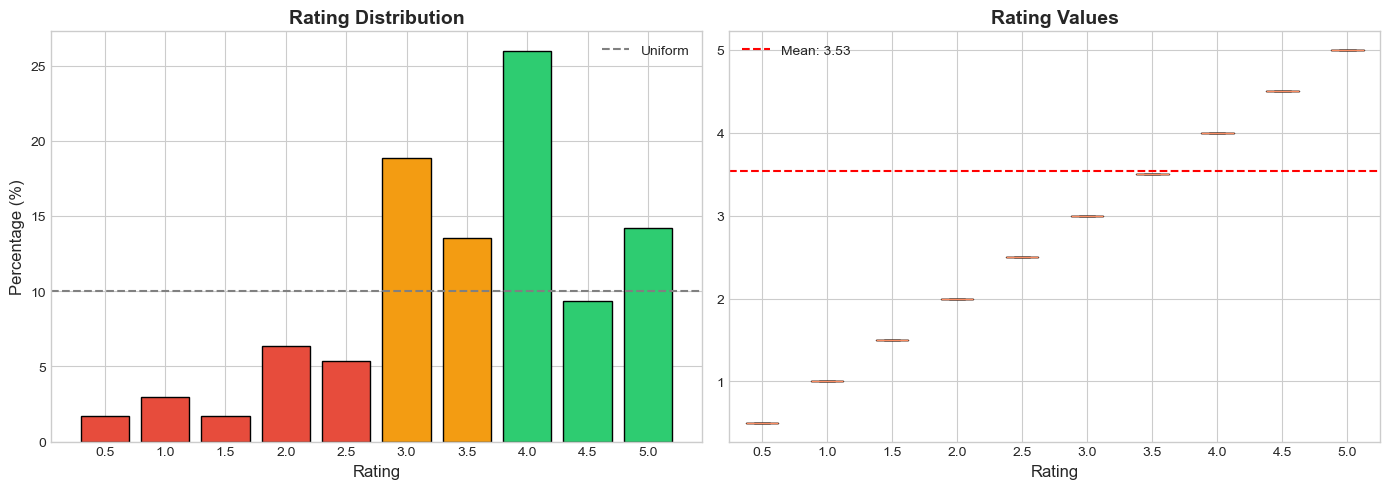


Conclusion: Ratings are left-skewed (positive bias)


In [6]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = ['#e74c3c' if r <= 2.5 else '#f39c12' if r <= 3.5 else '#2ecc71' for r in rating_dist.index]
axes[0].bar(rating_dist.index.astype(str), rating_dist.values * 100, color=colors, edgecolor='black')
axes[0].axhline(y=100/len(rating_dist), color='gray', linestyle='--', label='Uniform')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Percentage (%)', fontsize=12)
axes[0].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# Box plot by rating value
axes[1].boxplot([ratings_df[ratings_df['rating'] == r]['rating'] for r in sorted(ratings_df['rating'].unique())])
axes[1].set_xticklabels([str(r) for r in sorted(ratings_df['rating'].unique())])
axes[1].axhline(y=findings['rating_mean'], color='red', linestyle='--', label=f"Mean: {findings['rating_mean']:.2f}")
axes[1].set_xlabel('Rating', fontsize=12)
axes[1].set_title('Rating Values', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Determine skewness direction
findings['skew_direction'] = 'left-skewed (positive bias)' if findings['rating_skew'] < 0 else 'right-skewed' if findings['rating_skew'] > 0 else 'symmetric'
print(f"\nConclusion: Ratings are {findings['skew_direction']}")

---
## 2. User Statistics

In [7]:
print("=" * 60)
print("2. USER STATISTICS")
print("=" * 60)

user_stats = ratings_df.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std')
).reset_index()

findings['n_users'] = len(user_stats)
findings['user_ratings_mean'] = user_stats['num_ratings'].mean()
findings['user_ratings_median'] = user_stats['num_ratings'].median()
findings['user_ratings_min'] = user_stats['num_ratings'].min()
findings['user_ratings_max'] = user_stats['num_ratings'].max()

print(f"\nTotal users: {findings['n_users']:,}")
print(f"Ratings per user:")
print(f"  Mean: {findings['user_ratings_mean']:.1f}")
print(f"  Median: {findings['user_ratings_median']:.1f}")
print(f"  Min: {findings['user_ratings_min']}")
print(f"  Max: {findings['user_ratings_max']:,}")

# User activity segments
findings['users_5plus'] = (user_stats['num_ratings'] >= 5).sum()
findings['users_20plus'] = (user_stats['num_ratings'] >= 20).sum()
findings['users_50plus'] = (user_stats['num_ratings'] >= 50).sum()
findings['users_100plus'] = (user_stats['num_ratings'] >= 100).sum()

print(f"\nUser segments:")
print(f"  5+ ratings: {findings['users_5plus']:,} ({findings['users_5plus']/findings['n_users']*100:.1f}%)")
print(f"  20+ ratings: {findings['users_20plus']:,} ({findings['users_20plus']/findings['n_users']*100:.1f}%)")
print(f"  50+ ratings: {findings['users_50plus']:,} ({findings['users_50plus']/findings['n_users']*100:.1f}%)")
print(f"  100+ ratings: {findings['users_100plus']:,} ({findings['users_100plus']/findings['n_users']*100:.1f}%)")

2. USER STATISTICS

Total users: 60,284
Ratings per user:
  Mean: 160.2
  Median: 73.0
  Min: 18
  Max: 31,269

User segments:
  5+ ratings: 60,284 (100.0%)
  20+ ratings: 60,269 (100.0%)
  50+ ratings: 38,374 (63.7%)
  100+ ratings: 24,188 (40.1%)


In [8]:
# User bias analysis
global_mean = findings['rating_mean']
user_stats['bias'] = user_stats['avg_rating'] - global_mean

findings['user_bias_mean'] = user_stats['bias'].mean()
findings['user_bias_std'] = user_stats['bias'].std()
findings['users_positive_bias'] = (user_stats['bias'] > 0).sum()
findings['users_negative_bias'] = (user_stats['bias'] < 0).sum()

print(f"\nUser Bias Analysis:")
print(f"  Mean bias: {findings['user_bias_mean']:.3f}")
print(f"  Std bias: {findings['user_bias_std']:.3f}")
print(f"  Users with positive bias: {findings['users_positive_bias']:,} ({findings['users_positive_bias']/findings['n_users']*100:.1f}%)")
print(f"  Users with negative bias: {findings['users_negative_bias']:,} ({findings['users_negative_bias']/findings['n_users']*100:.1f}%)")

# Recommendation for bias handling
findings['needs_user_bias_correction'] = findings['user_bias_std'] > 0.5
print(f"\nBias correction recommended: {findings['needs_user_bias_correction']}")


User Bias Analysis:
  Mean bias: 0.171
  Std bias: 0.486
  Users with positive bias: 40,066 (66.5%)
  Users with negative bias: 20,218 (33.5%)

Bias correction recommended: False


---
## 3. Item (Movie) Statistics

In [9]:
print("=" * 60)
print("3. ITEM (MOVIE) STATISTICS")
print("=" * 60)

item_stats = ratings_df.groupby('movieId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean'),
    std_rating=('rating', 'std')
).reset_index()

findings['n_items'] = len(item_stats)
findings['item_ratings_mean'] = item_stats['num_ratings'].mean()
findings['item_ratings_median'] = item_stats['num_ratings'].median()
findings['item_ratings_min'] = item_stats['num_ratings'].min()
findings['item_ratings_max'] = item_stats['num_ratings'].max()

print(f"\nTotal items (movies): {findings['n_items']:,}")
print(f"Ratings per item:")
print(f"  Mean: {findings['item_ratings_mean']:.1f}")
print(f"  Median: {findings['item_ratings_median']:.1f}")
print(f"  Min: {findings['item_ratings_min']}")
print(f"  Max: {findings['item_ratings_max']:,}")

# Item popularity segments
findings['items_cf_eligible'] = (item_stats['num_ratings'] >= THRESHOLDS['cf_min_ratings']).sum()
findings['items_20plus'] = (item_stats['num_ratings'] >= 20).sum()
findings['items_100plus'] = (item_stats['num_ratings'] >= 100).sum()

print(f"\nItem segments:")
print(f"  CF-eligible (≥{THRESHOLDS['cf_min_ratings']}): {findings['items_cf_eligible']:,} ({findings['items_cf_eligible']/findings['n_items']*100:.1f}%)")
print(f"  20+ ratings: {findings['items_20plus']:,} ({findings['items_20plus']/findings['n_items']*100:.1f}%)")
print(f"  100+ ratings: {findings['items_100plus']:,} ({findings['items_100plus']/findings['n_items']*100:.1f}%)")

3. ITEM (MOVIE) STATISTICS

Total items (movies): 61,455
Ratings per item:
  Mean: 157.2
  Median: 4.0
  Min: 1
  Max: 30,821

Item segments:
  CF-eligible (≥5): 27,504 (44.8%)
  20+ ratings: 14,698 (23.9%)
  100+ ratings: 7,554 (12.3%)


In [10]:
# Long-tail analysis
item_stats_sorted = item_stats.sort_values('num_ratings', ascending=False).reset_index(drop=True)
item_stats_sorted['cumsum'] = item_stats_sorted['num_ratings'].cumsum()
item_stats_sorted['cumsum_pct'] = item_stats_sorted['cumsum'] / item_stats_sorted['num_ratings'].sum() * 100

# Find what % of items account for 80% of ratings
items_for_80 = (item_stats_sorted['cumsum_pct'] <= 80).sum()
findings['pct_items_for_80_ratings'] = items_for_80 / findings['n_items'] * 100

print(f"\nLong-tail Analysis:")
print(f"  Top {findings['pct_items_for_80_ratings']:.1f}% of items account for 80% of ratings")
print(f"  This indicates a {'severe' if findings['pct_items_for_80_ratings'] < 10 else 'moderate' if findings['pct_items_for_80_ratings'] < 20 else 'mild'} long-tail distribution")


Long-tail Analysis:
  Top 4.2% of items account for 80% of ratings
  This indicates a severe long-tail distribution


In [11]:
# Item bias analysis
item_stats['bias'] = item_stats['avg_rating'] - global_mean

findings['item_bias_mean'] = item_stats['bias'].mean()
findings['item_bias_std'] = item_stats['bias'].std()

print(f"\nItem Bias Analysis:")
print(f"  Mean bias: {findings['item_bias_mean']:.3f}")
print(f"  Std bias: {findings['item_bias_std']:.3f}")

findings['needs_item_bias_correction'] = findings['item_bias_std'] > 0.5
print(f"  Bias correction recommended: {findings['needs_item_bias_correction']}")


Item Bias Analysis:
  Mean bias: -0.541
  Std bias: 0.813
  Bias correction recommended: True


---
## 4. Sparsity Analysis

In [12]:
print("=" * 60)
print("4. SPARSITY ANALYSIS")
print("=" * 60)

n_ratings = len(ratings_df)
n_users = findings['n_users']
n_items = findings['n_items']
n_possible = n_users * n_items

findings['n_ratings'] = n_ratings
findings['n_possible_ratings'] = n_possible
findings['density'] = (n_ratings / n_possible) * 100
findings['sparsity'] = 100 - findings['density']

print(f"\nMatrix dimensions: {n_users:,} users × {n_items:,} items")
print(f"Possible ratings: {n_possible:,}")
print(f"Actual ratings: {n_ratings:,}")
print(f"Density: {findings['density']:.4f}%")
print(f"Sparsity: {findings['sparsity']:.4f}%")

# Determine if matrix factorization is needed
findings['mf_required'] = findings['density'] < THRESHOLDS['sparsity_mf_threshold']
print(f"\nMatrix Factorization required: {findings['mf_required']}")
print(f"  (Density {findings['density']:.4f}% {'<' if findings['mf_required'] else '>='} {THRESHOLDS['sparsity_mf_threshold']}% threshold)")

4. SPARSITY ANALYSIS

Matrix dimensions: 60,284 users × 61,455 items
Possible ratings: 3,704,753,220
Actual ratings: 9,659,235
Density: 0.2607%
Sparsity: 99.7393%

Matrix Factorization required: True
  (Density 0.2607% < 1.0% threshold)


---
## 5. User-User CF Feasibility

In [13]:
print("=" * 60)
print("5. USER-USER CF FEASIBILITY")
print("=" * 60)

# Sample active users for correlation analysis
min_ratings_for_cf = 50
active_users = user_stats[user_stats['num_ratings'] >= min_ratings_for_cf]['userId'].values
print(f"\nUsers with {min_ratings_for_cf}+ ratings: {len(active_users):,}")

# Sample users if too many
np.random.seed(42)
if len(active_users) > 1000:
    sample_users = np.random.choice(active_users, 1000, replace=False)
else:
    sample_users = active_users
print(f"Sampled users for analysis: {len(sample_users)}")

5. USER-USER CF FEASIBILITY

Users with 50+ ratings: 38,374
Sampled users for analysis: 1000


In [14]:
# Create user-item matrix for sampled users
sample_ratings = ratings_df[ratings_df['userId'].isin(sample_users)]
user_item_matrix = sample_ratings.pivot(index='userId', columns='movieId', values='rating')

print(f"User-Item matrix shape: {user_item_matrix.shape}")
print(f"Analyzing user-user correlations...")

User-Item matrix shape: (1000, 14898)
Analyzing user-user correlations...


In [15]:
# Calculate correlations between user pairs
min_shared_items = 5
correlations = []
pairs_analyzed = 0
pairs_with_overlap = 0

users = user_item_matrix.index.tolist()
n_sample = min(500, len(users))  # Limit for speed
sample_idx = np.random.choice(len(users), n_sample, replace=False)

for i in range(len(sample_idx)):
    for j in range(i+1, len(sample_idx)):
        u1, u2 = users[sample_idx[i]], users[sample_idx[j]]
        r1 = user_item_matrix.loc[u1]
        r2 = user_item_matrix.loc[u2]
        
        # Find shared items
        shared = r1.notna() & r2.notna()
        n_shared = shared.sum()
        pairs_analyzed += 1
        
        if n_shared >= min_shared_items:
            pairs_with_overlap += 1
            corr = r1[shared].corr(r2[shared])
            if not np.isnan(corr):
                correlations.append(corr)

print(f"\nPairs analyzed: {pairs_analyzed:,}")
print(f"Pairs with {min_shared_items}+ shared items: {pairs_with_overlap:,}")


Pairs analyzed: 124,750
Pairs with 5+ shared items: 102,453


In [16]:
# Store User-User CF findings
findings['uu_pairs_analyzed'] = pairs_analyzed
findings['uu_pairs_with_overlap'] = pairs_with_overlap
findings['uu_overlap_pct'] = (pairs_with_overlap / pairs_analyzed * 100) if pairs_analyzed > 0 else 0

if len(correlations) > 0:
    findings['uu_corr_mean'] = np.mean(correlations)
    findings['uu_corr_std'] = np.std(correlations)
    findings['uu_positive_corr_pct'] = (np.array(correlations) > 0).sum() / len(correlations) * 100
    findings['uu_strong_corr_pct'] = (np.abs(correlations) > 0.3).sum() / len(correlations) * 100
else:
    findings['uu_corr_mean'] = 0
    findings['uu_corr_std'] = 0
    findings['uu_positive_corr_pct'] = 0
    findings['uu_strong_corr_pct'] = 0

print(f"\nUser-User Correlation Results:")
print(f"  Valid correlations: {len(correlations):,}")
print(f"  Overlap percentage: {findings['uu_overlap_pct']:.2f}%")
print(f"  Mean correlation: {findings['uu_corr_mean']:.3f}")
print(f"  Std correlation: {findings['uu_corr_std']:.3f}")
print(f"  Positive correlations: {findings['uu_positive_corr_pct']:.1f}%")
print(f"  Strong correlations (|r|>0.3): {findings['uu_strong_corr_pct']:.1f}%")


User-User Correlation Results:
  Valid correlations: 101,082
  Overlap percentage: 82.13%
  Mean correlation: 0.114
  Std correlation: 0.305
  Positive correlations: 66.6%
  Strong correlations (|r|>0.3): 35.6%


In [17]:
# Determine User-User CF viability
findings['uu_cf_viable'] = (
    findings['uu_overlap_pct'] >= THRESHOLDS['min_overlap_pairs_pct'] and
    findings['uu_corr_mean'] >= THRESHOLDS['min_correlation'] and
    findings['uu_positive_corr_pct'] >= THRESHOLDS['min_positive_corr_pct']
)

print(f"\nUser-User CF Viability: {'VIABLE' if findings['uu_cf_viable'] else 'NOT VIABLE'}")
print(f"  Overlap {findings['uu_overlap_pct']:.2f}% {'≥' if findings['uu_overlap_pct'] >= THRESHOLDS['min_overlap_pairs_pct'] else '<'} {THRESHOLDS['min_overlap_pairs_pct']}%: {'✓' if findings['uu_overlap_pct'] >= THRESHOLDS['min_overlap_pairs_pct'] else '✗'}")
print(f"  Mean corr {findings['uu_corr_mean']:.3f} {'≥' if findings['uu_corr_mean'] >= THRESHOLDS['min_correlation'] else '<'} {THRESHOLDS['min_correlation']}: {'✓' if findings['uu_corr_mean'] >= THRESHOLDS['min_correlation'] else '✗'}")
print(f"  Positive {findings['uu_positive_corr_pct']:.1f}% {'≥' if findings['uu_positive_corr_pct'] >= THRESHOLDS['min_positive_corr_pct'] else '<'} {THRESHOLDS['min_positive_corr_pct']}%: {'✓' if findings['uu_positive_corr_pct'] >= THRESHOLDS['min_positive_corr_pct'] else '✗'}")


User-User CF Viability: NOT VIABLE
  Overlap 82.13% ≥ 0.01%: ✓
  Mean corr 0.114 < 0.2: ✗
  Positive 66.6% ≥ 60%: ✓


---
## 6. Item-Item CF Feasibility

In [18]:
print("=" * 60)
print("6. ITEM-ITEM CF FEASIBILITY")
print("=" * 60)

# Get popular items for analysis
min_ratings_for_item = 100
popular_items = item_stats[item_stats['num_ratings'] >= min_ratings_for_item]['movieId'].values
print(f"\nItems with {min_ratings_for_item}+ ratings: {len(popular_items):,}")

# Sample items
np.random.seed(42)
if len(popular_items) > 500:
    sample_items = np.random.choice(popular_items, 500, replace=False)
else:
    sample_items = popular_items
print(f"Sampled items for analysis: {len(sample_items)}")

6. ITEM-ITEM CF FEASIBILITY

Items with 100+ ratings: 7,554
Sampled items for analysis: 500


In [19]:
# Create item-user matrix (transpose)
sample_ratings_items = ratings_df[ratings_df['movieId'].isin(sample_items)]
item_user_matrix = sample_ratings_items.pivot(index='movieId', columns='userId', values='rating')

print(f"Item-User matrix shape: {item_user_matrix.shape}")
print(f"Analyzing item-item correlations...")

Item-User matrix shape: (500, 56534)
Analyzing item-item correlations...


In [20]:
# Calculate correlations between item pairs
min_shared_users = 20
item_correlations = []
item_pairs_analyzed = 0
item_pairs_with_overlap = 0

items = item_user_matrix.index.tolist()
n_sample_items = min(300, len(items))
sample_item_idx = np.random.choice(len(items), n_sample_items, replace=False)

for i in range(len(sample_item_idx)):
    for j in range(i+1, len(sample_item_idx)):
        i1, i2 = items[sample_item_idx[i]], items[sample_item_idx[j]]
        r1 = item_user_matrix.loc[i1]
        r2 = item_user_matrix.loc[i2]
        
        # Find shared users
        shared = r1.notna() & r2.notna()
        n_shared = shared.sum()
        item_pairs_analyzed += 1
        
        if n_shared >= min_shared_users:
            item_pairs_with_overlap += 1
            corr = r1[shared].corr(r2[shared])
            if not np.isnan(corr):
                item_correlations.append(corr)

print(f"\nPairs analyzed: {item_pairs_analyzed:,}")
print(f"Pairs with {min_shared_users}+ shared users: {item_pairs_with_overlap:,}")


Pairs analyzed: 44,850
Pairs with 20+ shared users: 26,290


In [21]:
# Store Item-Item CF findings
findings['ii_pairs_analyzed'] = item_pairs_analyzed
findings['ii_pairs_with_overlap'] = item_pairs_with_overlap
findings['ii_overlap_pct'] = (item_pairs_with_overlap / item_pairs_analyzed * 100) if item_pairs_analyzed > 0 else 0

if len(item_correlations) > 0:
    findings['ii_corr_mean'] = np.mean(item_correlations)
    findings['ii_corr_std'] = np.std(item_correlations)
    findings['ii_positive_corr_pct'] = (np.array(item_correlations) > 0).sum() / len(item_correlations) * 100
    findings['ii_strong_corr_pct'] = (np.abs(item_correlations) > 0.3).sum() / len(item_correlations) * 100
else:
    findings['ii_corr_mean'] = 0
    findings['ii_corr_std'] = 0
    findings['ii_positive_corr_pct'] = 0
    findings['ii_strong_corr_pct'] = 0

print(f"\nItem-Item Correlation Results:")
print(f"  Valid correlations: {len(item_correlations):,}")
print(f"  Overlap percentage: {findings['ii_overlap_pct']:.2f}%")
print(f"  Mean correlation: {findings['ii_corr_mean']:.3f}")
print(f"  Std correlation: {findings['ii_corr_std']:.3f}")
print(f"  Positive correlations: {findings['ii_positive_corr_pct']:.1f}%")
print(f"  Strong correlations (|r|>0.3): {findings['ii_strong_corr_pct']:.1f}%")


Item-Item Correlation Results:
  Valid correlations: 26,290
  Overlap percentage: 58.62%
  Mean correlation: 0.252
  Std correlation: 0.185
  Positive correlations: 91.6%
  Strong correlations (|r|>0.3): 40.0%


In [22]:
# Determine Item-Item CF viability
findings['ii_cf_viable'] = (
    findings['ii_overlap_pct'] >= THRESHOLDS['min_overlap_pairs_pct'] and
    findings['ii_corr_mean'] >= THRESHOLDS['min_correlation'] and
    findings['ii_positive_corr_pct'] >= THRESHOLDS['min_positive_corr_pct']
)

print(f"\nItem-Item CF Viability: {'VIABLE' if findings['ii_cf_viable'] else 'NOT VIABLE'}")
print(f"  Overlap {findings['ii_overlap_pct']:.2f}% {'≥' if findings['ii_overlap_pct'] >= THRESHOLDS['min_overlap_pairs_pct'] else '<'} {THRESHOLDS['min_overlap_pairs_pct']}%: {'✓' if findings['ii_overlap_pct'] >= THRESHOLDS['min_overlap_pairs_pct'] else '✗'}")
print(f"  Mean corr {findings['ii_corr_mean']:.3f} {'≥' if findings['ii_corr_mean'] >= THRESHOLDS['min_correlation'] else '<'} {THRESHOLDS['min_correlation']}: {'✓' if findings['ii_corr_mean'] >= THRESHOLDS['min_correlation'] else '✗'}")
print(f"  Positive {findings['ii_positive_corr_pct']:.1f}% {'≥' if findings['ii_positive_corr_pct'] >= THRESHOLDS['min_positive_corr_pct'] else '<'} {THRESHOLDS['min_positive_corr_pct']}%: {'✓' if findings['ii_positive_corr_pct'] >= THRESHOLDS['min_positive_corr_pct'] else '✗'}")


Item-Item CF Viability: VIABLE
  Overlap 58.62% ≥ 0.01%: ✓
  Mean corr 0.252 ≥ 0.2: ✓
  Positive 91.6% ≥ 60%: ✓


---
## 7. Content-Based Feasibility (Genre Analysis)

In [23]:
print("=" * 60)
print("7. CONTENT-BASED FEASIBILITY")
print("=" * 60)

# Extract genres
genres_expanded = movies_df.assign(genre=movies_df['genres'].str.split('|')).explode('genre')
genre_stats = genres_expanded.groupby('genre').size().sort_values(ascending=False)

findings['n_genres'] = len(genre_stats)
findings['top_genre'] = genre_stats.index[0]
findings['top_genre_count'] = genre_stats.iloc[0]

print(f"\nTotal genres: {findings['n_genres']}")
print(f"\nGenre distribution:")
for genre, count in genre_stats.head(10).items():
    print(f"  {genre}: {count:,} movies")

7. CONTENT-BASED FEASIBILITY

Total genres: 19

Genre distribution:
  Drama: 27,116 movies
  Comedy: 17,991 movies
  Thriller: 9,325 movies
  Romance: 7,892 movies
  Action: 7,529 movies
  Documentary: 6,751 movies
  Horror: 6,678 movies
  Crime: 5,401 movies
  Adventure: 4,315 movies
  Sci-Fi: 3,946 movies


In [24]:
# ANOVA test: Do genres predict ratings?
# Merge ratings with genres
ratings_with_genres = ratings_df.merge(movies_df[['movieId', 'genres']], on='movieId')
ratings_with_genres['primary_genre'] = ratings_with_genres['genres'].str.split('|').str[0]

# Get ratings by genre
genre_groups = [group['rating'].values for name, group in ratings_with_genres.groupby('primary_genre')]

# Perform ANOVA
f_stat, p_value = stats.f_oneway(*genre_groups)

findings['genre_anova_f'] = f_stat
findings['genre_anova_p'] = p_value
findings['cb_viable'] = p_value < THRESHOLDS['anova_p_threshold']

print(f"\nANOVA Test (Genre → Rating):")
print(f"  F-statistic: {f_stat:.2f}")
print(f"  P-value: {p_value:.2e}")
print(f"\nContent-Based Viability: {'VIABLE' if findings['cb_viable'] else 'NOT VIABLE'}")
print(f"  P-value {p_value:.2e} {'<' if p_value < THRESHOLDS['anova_p_threshold'] else '≥'} {THRESHOLDS['anova_p_threshold']}: {'✓' if findings['cb_viable'] else '✗'}")


ANOVA Test (Genre → Rating):
  F-statistic: 9624.98
  P-value: 0.00e+00

Content-Based Viability: VIABLE
  P-value 0.00e+00 < 0.05: ✓


In [25]:
# Average rating by genre
genre_ratings = ratings_with_genres.groupby('primary_genre')['rating'].agg(['mean', 'std', 'count'])
genre_ratings = genre_ratings.sort_values('mean', ascending=False)

print(f"\nAverage rating by genre (top 10):")
print(genre_ratings.head(10).to_string())

# Calculate genre rating variance
findings['genre_rating_variance'] = genre_ratings['mean'].var()
print(f"\nVariance in genre means: {findings['genre_rating_variance']:.4f}")
print(f"This indicates {'significant' if findings['genre_rating_variance'] > 0.01 else 'minimal'} differentiation by genre")


Average rating by genre (top 10):
                   mean       std    count
primary_genre                             
Film-Noir      3.995762  0.916999    11799
Mystery        3.877895  0.931242    96216
Crime          3.825453  0.946976   676574
Documentary    3.701938  1.015469   111846
Drama          3.661180  0.997292  1829790
Western        3.593018  0.959441    18534
Adventure      3.575188  1.058687   970870
Sci-Fi         3.570996  1.094304    48390
War            3.569474  0.939124     1900
Animation      3.547900  1.065216   233369

Variance in genre means: 0.1383
This indicates significant differentiation by genre


---
## 8. Popularity Bias Analysis

In [26]:
print("=" * 60)
print("8. POPULARITY BIAS ANALYSIS")
print("=" * 60)

# Correlation between popularity and rating
popularity_rating_corr = item_stats['num_ratings'].corr(item_stats['avg_rating'])
findings['popularity_rating_corr'] = popularity_rating_corr

print(f"\nCorrelation (popularity vs rating): {popularity_rating_corr:.4f}")

# Interpret
if abs(popularity_rating_corr) < 0.1:
    findings['popularity_bias'] = 'NONE'
    findings['popularity_bias_action'] = 'No debiasing needed'
elif abs(popularity_rating_corr) < 0.2:
    findings['popularity_bias'] = 'WEAK'
    findings['popularity_bias_action'] = 'Minor debiasing optional'
elif abs(popularity_rating_corr) < 0.4:
    findings['popularity_bias'] = 'MODERATE'
    findings['popularity_bias_action'] = 'Consider popularity debiasing'
else:
    findings['popularity_bias'] = 'STRONG'
    findings['popularity_bias_action'] = 'Popularity debiasing recommended'

print(f"Popularity bias: {findings['popularity_bias']}")
print(f"Recommendation: {findings['popularity_bias_action']}")

8. POPULARITY BIAS ANALYSIS

Correlation (popularity vs rating): 0.1149
Popularity bias: WEAK
Recommendation: Minor debiasing optional


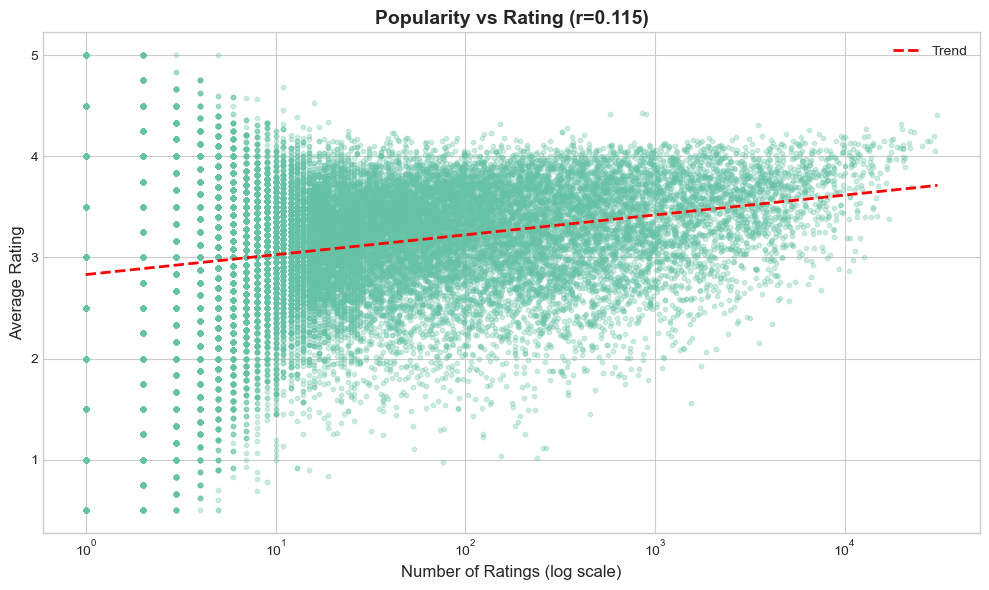

In [27]:
# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(item_stats['num_ratings'], item_stats['avg_rating'], alpha=0.3, s=10)
ax.set_xscale('log')
ax.set_xlabel('Number of Ratings (log scale)', fontsize=12)
ax.set_ylabel('Average Rating', fontsize=12)
ax.set_title(f'Popularity vs Rating (r={popularity_rating_corr:.3f})', fontsize=14, fontweight='bold')

# Add trend line
z = np.polyfit(np.log10(item_stats['num_ratings']), item_stats['avg_rating'], 1)
p = np.poly1d(z)
x_trend = np.logspace(0, np.log10(item_stats['num_ratings'].max()), 100)
ax.plot(x_trend, p(np.log10(x_trend)), 'r--', linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.show()

---
## 9. Cold Start Analysis

In [28]:
print("=" * 60)
print("9. COLD START ANALYSIS")
print("=" * 60)

# Items with few ratings (cold start items)
cold_items_1 = (item_stats['num_ratings'] == 1).sum()
cold_items_5 = (item_stats['num_ratings'] < 5).sum()
cold_items_10 = (item_stats['num_ratings'] < 10).sum()

findings['cold_items_1'] = cold_items_1
findings['cold_items_5'] = cold_items_5
findings['cold_items_10'] = cold_items_10
findings['cold_items_pct'] = cold_items_5 / findings['n_items'] * 100

print(f"\nCold Start Items:")
print(f"  1 rating only: {cold_items_1:,} ({cold_items_1/findings['n_items']*100:.1f}%)")
print(f"  <5 ratings: {cold_items_5:,} ({cold_items_5/findings['n_items']*100:.1f}%)")
print(f"  <10 ratings: {cold_items_10:,} ({cold_items_10/findings['n_items']*100:.1f}%)")

# Users with few ratings (cold start users)
cold_users_5 = (user_stats['num_ratings'] < 5).sum()
cold_users_10 = (user_stats['num_ratings'] < 10).sum()

findings['cold_users_5'] = cold_users_5
findings['cold_users_10'] = cold_users_10
findings['cold_users_pct'] = cold_users_5 / findings['n_users'] * 100

print(f"\nCold Start Users:")
print(f"  <5 ratings: {cold_users_5:,} ({cold_users_5/findings['n_users']*100:.1f}%)")
print(f"  <10 ratings: {cold_users_10:,} ({cold_users_10/findings['n_users']*100:.1f}%)")

# Cold start severity
if findings['cold_items_pct'] > 50:
    findings['cold_start_severity'] = 'SEVERE'
    findings['cold_start_action'] = 'Content-based fallback essential'
elif findings['cold_items_pct'] > 30:
    findings['cold_start_severity'] = 'MODERATE'
    findings['cold_start_action'] = 'Hybrid approach recommended'
else:
    findings['cold_start_severity'] = 'MILD'
    findings['cold_start_action'] = 'CF can handle most cases'

print(f"\nCold Start Severity: {findings['cold_start_severity']}")
print(f"Recommendation: {findings['cold_start_action']}")

9. COLD START ANALYSIS

Cold Start Items:
  1 rating only: 16,780 (27.3%)
  <5 ratings: 33,951 (55.2%)
  <10 ratings: 41,724 (67.9%)

Cold Start Users:
  <5 ratings: 0 (0.0%)
  <10 ratings: 0 (0.0%)

Cold Start Severity: SEVERE
Recommendation: Content-based fallback essential


---
## 10. Temporal Analysis

In [29]:
print("=" * 60)
print("10. TEMPORAL ANALYSIS")
print("=" * 60)

# Convert timestamp
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df['month'] = ratings_df['datetime'].dt.to_period('M')

findings['date_min'] = ratings_df['datetime'].min()
findings['date_max'] = ratings_df['datetime'].max()
findings['date_range_years'] = (findings['date_max'] - findings['date_min']).days / 365

print(f"\nDate range: {findings['date_min'].date()} to {findings['date_max'].date()}")
print(f"Duration: {findings['date_range_years']:.1f} years")

10. TEMPORAL ANALYSIS

Date range: 1995-01-09 to 2023-10-13
Duration: 28.8 years


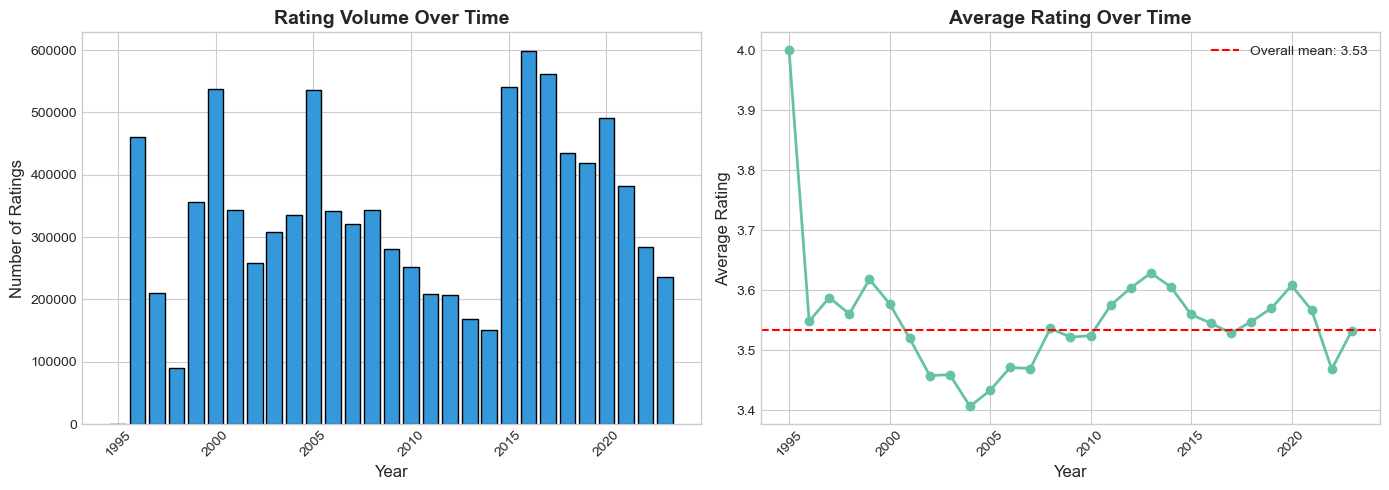


Temporal drift correlation: -0.179
Significant drift: False
Recommendation: Random split acceptable


In [30]:
# Ratings over time
yearly_ratings = ratings_df.groupby('year').size()
yearly_avg_rating = ratings_df.groupby('year')['rating'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rating volume over time
axes[0].bar(yearly_ratings.index, yearly_ratings.values, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Number of Ratings', fontsize=12)
axes[0].set_title('Rating Volume Over Time', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Average rating over time
axes[1].plot(yearly_avg_rating.index, yearly_avg_rating.values, marker='o', linewidth=2, markersize=6)
axes[1].axhline(y=findings['rating_mean'], color='red', linestyle='--', label=f"Overall mean: {findings['rating_mean']:.2f}")
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Average Rating', fontsize=12)
axes[1].set_title('Average Rating Over Time', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Check for temporal drift
rating_trend_corr = yearly_avg_rating.reset_index()['rating'].corr(pd.Series(range(len(yearly_avg_rating))))
findings['temporal_drift'] = abs(rating_trend_corr) > 0.3
findings['temporal_drift_corr'] = rating_trend_corr

print(f"\nTemporal drift correlation: {rating_trend_corr:.3f}")
print(f"Significant drift: {findings['temporal_drift']}")
print(f"Recommendation: {'Use temporal split for train/test' if findings['temporal_drift'] else 'Random split acceptable'}")

---
## Phase 2 Summary (Dynamic)

In [31]:
print("=" * 70)
print("PHASE 2 SUMMARY: EDA INSIGHTS")
print("=" * 70)

print("\n" + "-" * 70)
print("1. DATASET OVERVIEW")
print("-" * 70)
print(f"   Ratings: {findings['n_ratings']:,}")
print(f"   Users: {findings['n_users']:,}")
print(f"   Items: {findings['n_items']:,}")
print(f"   Density: {findings['density']:.4f}%")
print(f"   Sparsity: {findings['sparsity']:.2f}%")

print("\n" + "-" * 70)
print("2. RATING PATTERNS")
print("-" * 70)
print(f"   Mean: {findings['rating_mean']:.2f}")
print(f"   Median: {findings['rating_median']:.1f}")
print(f"   Mode: {findings['rating_mode']}")
print(f"   Distribution: {findings['skew_direction']}")

print("\n" + "-" * 70)
print("3. USER-USER CF FEASIBILITY")
print("-" * 70)
print(f"   Pairs with overlap: {findings['uu_overlap_pct']:.2f}%")
print(f"   Mean correlation: {findings['uu_corr_mean']:.3f}")
print(f"   Positive correlations: {findings['uu_positive_corr_pct']:.1f}%")
uu_status = '✓ VIABLE' if findings['uu_cf_viable'] else '✗ NOT VIABLE'
print(f"   Status: {uu_status}")

print("\n" + "-" * 70)
print("4. ITEM-ITEM CF FEASIBILITY")
print("-" * 70)
print(f"   Pairs with overlap: {findings['ii_overlap_pct']:.2f}%")
print(f"   Mean correlation: {findings['ii_corr_mean']:.3f}")
print(f"   Positive correlations: {findings['ii_positive_corr_pct']:.1f}%")
ii_status = '✓ VIABLE' if findings['ii_cf_viable'] else '✗ NOT VIABLE'
print(f"   Status: {ii_status}")

print("\n" + "-" * 70)
print("5. CONTENT-BASED FEASIBILITY")
print("-" * 70)
print(f"   Genres: {findings['n_genres']}")
print(f"   ANOVA F-stat: {findings['genre_anova_f']:.2f}")
print(f"   ANOVA p-value: {findings['genre_anova_p']:.2e}")
cb_status = '✓ VIABLE' if findings['cb_viable'] else '✗ NOT VIABLE'
print(f"   Status: {cb_status}")

print("\n" + "-" * 70)
print("6. BIAS ANALYSIS")
print("-" * 70)
print(f"   User bias std: {findings['user_bias_std']:.3f} → {'Correction needed' if findings['needs_user_bias_correction'] else 'OK'}")
print(f"   Item bias std: {findings['item_bias_std']:.3f} → {'Correction needed' if findings['needs_item_bias_correction'] else 'OK'}")
print(f"   Popularity bias: {findings['popularity_bias']} (r={findings['popularity_rating_corr']:.3f})")

print("\n" + "-" * 70)
print("7. COLD START")
print("-" * 70)
print(f"   Cold items (<5 ratings): {findings['cold_items_5']:,} ({findings['cold_items_pct']:.1f}%)")
print(f"   Cold users (<5 ratings): {findings['cold_users_5']:,} ({findings['cold_users_pct']:.1f}%)")
print(f"   Severity: {findings['cold_start_severity']}")

print("\n" + "-" * 70)
print("8. TEMPORAL")
print("-" * 70)
print(f"   Date range: {findings['date_min'].date()} to {findings['date_max'].date()}")
print(f"   Drift detected: {'Yes' if findings['temporal_drift'] else 'No'}")

PHASE 2 SUMMARY: EDA INSIGHTS

----------------------------------------------------------------------
1. DATASET OVERVIEW
----------------------------------------------------------------------
   Ratings: 9,659,235
   Users: 60,284
   Items: 61,455
   Density: 0.2607%
   Sparsity: 99.74%

----------------------------------------------------------------------
2. RATING PATTERNS
----------------------------------------------------------------------
   Mean: 3.53
   Median: 3.5
   Mode: 4.0
   Distribution: left-skewed (positive bias)

----------------------------------------------------------------------
3. USER-USER CF FEASIBILITY
----------------------------------------------------------------------
   Pairs with overlap: 82.13%
   Mean correlation: 0.114
   Positive correlations: 66.6%
   Status: ✗ NOT VIABLE

----------------------------------------------------------------------
4. ITEM-ITEM CF FEASIBILITY
----------------------------------------------------------------------
   Pair

In [32]:
# Dynamic Recommendations
print("\n" + "=" * 70)
print("MODELING RECOMMENDATIONS")
print("=" * 70)

recommendations = []

# 1. CF approach
if findings['mf_required']:  # density < 1%
    if findings['ii_cf_viable'] and findings['uu_cf_viable']:
        recommendations.append("Use Matrix Factorization (SVD/ALS) - recommended for sparse data")
        recommendations.append("Both User-User and Item-Item CF also viable as alternatives")
    elif findings['ii_cf_viable']:
        recommendations.append("Use Matrix Factorization (SVD/ALS) - recommended for sparse data")
        recommendations.append(f"Item-Item CF also viable as alternative (r={findings['ii_corr_mean']:.3f})")
    elif findings['uu_cf_viable']:
        recommendations.append("Use Matrix Factorization (SVD/ALS) - recommended for sparse data")
        recommendations.append("User-User CF also viable as alternative")
    else:
        recommendations.append("Use Matrix Factorization (SVD/ALS) - REQUIRED (CF methods not viable)")
else:  # density >= 1%, CF can work directly
    if findings['ii_cf_viable'] and not findings['uu_cf_viable']:
        recommendations.append("Use Item-Item CF - better overlap than User-User")
    elif findings['uu_cf_viable'] and findings['ii_cf_viable']:
        recommendations.append("Both User-User and Item-Item CF viable - test both")
    elif findings['uu_cf_viable']:
        recommendations.append("Use User-User CF")
    else:
        recommendations.append("Use Matrix Factorization (SVD/ALS) - CF methods not viable")

# 2. Hybrid
if findings['cb_viable'] and findings['cold_start_severity'] in ['MODERATE', 'SEVERE']:
    recommendations.append("Use HYBRID approach - Content-based needed for cold start")
elif findings['cb_viable']:
    recommendations.append("Content-based optional - can improve recommendations")

# 3. Bias handling
if findings['needs_user_bias_correction'] or findings['needs_item_bias_correction']:
    recommendations.append("Apply bias correction (subtract user/item means)")

# 4. Popularity
if findings['popularity_bias'] in ['MODERATE', 'STRONG']:
    recommendations.append(f"Apply popularity debiasing - {findings['popularity_bias']} bias detected")

# 5. Train/test split
if findings['temporal_drift']:
    recommendations.append("Use TEMPORAL split for train/val/test (drift detected)")
else:
    recommendations.append("Random or temporal split both acceptable")

for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec}")

print("\n" + "=" * 70)
print("READY FOR PHASE 3: ML PREPROCESSING")
print("=" * 70)


MODELING RECOMMENDATIONS
  1. Use Matrix Factorization (SVD/ALS) - recommended for sparse data
  2. Item-Item CF also viable as alternative (r=0.252)
  3. Use HYBRID approach - Content-based needed for cold start
  4. Apply bias correction (subtract user/item means)
  5. Random or temporal split both acceptable

READY FOR PHASE 3: ML PREPROCESSING
